# Translation with Sequence-to-Sequence Models in PyTorch

Sequence-to-sequence models are a general class of recurrent neural networks which map an input sequence to an output sequence. The high-level architecture is based on a classic idea in information theory where an input signal is processed by an _encode_, _transmitted_ and then _decoded_ by another model to produce an output signal.

In sequence-to-sequence models the _encoder_ and _decoder_ are recurrent neural networks (or some variant) themselves. The basic idea generalises to a wide variety of architectures, as long as they are end-to-end differentiable.

Here I will follow this [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#sphx-glr-intermediate-seq2seq-translation-tutorial-py) except to translate English sentences into French sentences.

In [1]:
import os
import re
import time
import math
import string
import glob
import random
import unicodedata

from io import open

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

HOME = os.environ['AI_HOME']
ROOT = os.path.join(HOME, 'artificial_neural_networks')
DATA = os.path.join(ROOT, 'data')
ENG_FR = os.path.join(DATA, 'english_french')

random.seed(1901)
np.random.seed(1901)
torch.manual_seed(1901)

## Data Preprocessing

English-French sentence pairs can be downloaded [here](https://download.pytorch.org/tutorial/data.zip) (the original data comes from [https://tatoeba.org/eng/downloads](https://tatoeba.org/eng/downloads) and has been paired thanks to [https://www.manythings.org/anki/](https://www.manythings.org/anki/). 

Once again we'll need to do the hardwork of preprocessing this data into tensors which we can feed into our model. Since this is a sequence-to-sequence model, we'll need to be careful to ensure that pairs of input-output sequences are aligned during training.

The data is stored on one file with each line representing an English-French sentence pair. Each English and French sentence is separated by a tab.

### String Encoding and Normalisation

The files are all in unicode which we will simplify to ASCII.

In [2]:
def unicode_to_ascii(string_):
    # ref: https://stackoverflow.com/a/518232/2809427
    return ''.join(
        char for char in unicodedata.normalize('NFD', string_)  # Unicode normal form decomposition of character
        if unicodedata.category(char) != 'Mn')  # non-spacing mark characters

In [3]:
sentences = open(os.path.join(ENG_FR, 'eng-fra.txt'), encoding='utf-8').read().strip().split('\n')

for line in sentences[:5]:
    print(unicode_to_ascii(line))

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ca alors !
Fire!	Au feu !


It will be helpful to normalise the strings to lowercase and remove non-letter characters.

In [4]:
def normalize_string(string_):
    string_ = unicode_to_ascii(string_.lower().strip())
    string_ = re.sub(r"([.!?])", r" \1", string_)
    string_ = re.sub(r"[^a-zA-Z.!?]+", r" ", string_)
    return string_

In [5]:
for line in sentences[:5]:
    print(normalize_string(line))

go . va !
run ! cours !
run ! courez !
wow ! ca alors !
fire ! au feu !


### Vocabulary Indexing

The English and French sentences need to be indexed for conversion to tensors. However we'll need to be careful not to mix up the indexing between the two languages. To save time and ensure that preprocessing scopes are kept local to each language we'll implement a class to manage preprocessing for each.

Each vocabulary will be a dictionary map between words and a unique index representing their one-hot-encoding index.

In sequence-to-sequence models we also use two special tokens to indicate the start and end of sentence. These will be the first two tokens in our dictionary mapping for each language.

<img src="assets/word-encoding.png">

In [6]:
SOS_token = 0
EOS_token = 1

class Vocab:
    
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # only have SOS and EOS so far

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words  # use total count to index new word
            self.index2word[self.n_words] = word 
            self.word2count[word] = 1
            self.n_words += 1 
        else:
            self.word2count[word] += 1
        

We'll use this class to maps words to indices and indices back to words.

## File-Vocabulary I/O

Next we'll define a function to read in language pairs and create vocabularies. We've seen earlier that the sentence pairs are in the order `English -> French`. If we want to reverse the translation we can use a reverse flag to change which language is the input language and which is the output language.

In [7]:
def read_vocab(path, in_lang, out_lang, reverse=False):
    """
    Args:
        path (str): Path to language file in form: lang1-lang2.txt.
        in_lang (str): Name to use for input language.
        out_lang (str): Name to use for output language.
        reverse (bool): If true reverse the roles of in_lang and out_lang.
        
    Note:
        The sentence pairs are always parsed as in_lang -> out_lang,
        unless reverse is true.
    """
    
    # read the file and split into lines
    sentences = open(path, encoding='utf-8').\
        read().strip().split('\n')
    
    # split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in sentences]  # [[en_1, fr_1], [en2_, fr_2], ... ]
    
    # init vocabularies
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_vocab = Vocab(out_lang)
        output_vocab = Vocab(in_lang)
    else:
        input_vocab = Vocab(in_lang)
        output_vocab = Vocab(out_lang)

    return input_vocab, output_vocab, pairs
    

### Sequence Filters

To make training quick and to reduce model size and complexity we'll restrict sentences to a maximum sequence length (including ending punctuation).

We'll also filter to the specific case translating to sentences of the form "He is ...", "She is ..." etc.

In [8]:
def keep(pair, max_seq_length, reverse=False):
    eng_sent_prefixes = ("i am ", "i m ",
                    "he is", "he s ",
                    "she is", "she s ",
                    "you are", "you re ",
                    "we are", "we re ",
                    "they are", "they re ")
    if reverse:
        eng = pair[1]
        fr = pair[0]
    else:
        eng = pair[0]
        fr = pair[1]
        
    condition =  len(fr.split(' ')) < max_seq_length and \
                 len(eng.split(' ')) < max_seq_length and eng.startswith(eng_sent_prefixes)
    
    return condition

def filter_pairs(pairs, max_seq_length, reverse=False):
    return [pair for pair in pairs if keep(pair, max_seq_length, reverse)]

### Preprocessing: Putting Everything Together

We'll use one function which handles all the preprocessing (this could also be implemented as a class with greater engineering sophistication and complexity), covering:

- read sentences, split into pairs and init vocabs
- filter pairs by length and content (if they start with certain prefixes)
- encode each pair as ASCII and normalise
- add new words to each respective vocabulary

In [9]:
def preprocess_sentence_pairs(path, in_lang, out_lang, max_seq_length, reverse=False):
    
    input_vocab, output_vocab, pairs = read_vocab(path, in_lang, out_lang, reverse)
    print(f"Total number of {in_lang}-{out_lang} sentence pairs: {len(pairs)}")
    
    pairs = filter_pairs(pairs, max_seq_length, reverse)
    print(f"Total number of pairs after filtering: {len(pairs)}")
    
    print("Adding words to respective vocabularies ...")
    for pair in pairs:
        input_vocab.add_sentence(pair[0])
        output_vocab.add_sentence(pair[1])
    
    print("Total number of words:")
    print(f"\tInput: {input_vocab.name}: {input_vocab.n_words}")
    print(f"\tOutput: {output_vocab.name}: {output_vocab.n_words}")
    
    return input_vocab, output_vocab, pairs
    

In [10]:
input_vocab, output_vocab, pairs = preprocess_sentence_pairs(
                                        path = os.path.join(ENG_FR, 'eng-fra.txt'), 
                                        in_lang = "English", 
                                        out_lang = "French", 
                                        max_seq_length = 10, 
                                        reverse=False)

Total number of English-French sentence pairs: 135842
Total number of pairs after filtering: 10599
Adding words to respective vocabularies ...
Total number of words:
	Input: English: 2803
	Output: French: 4345


## Conversion to Tensors

Now that we've done preprocessing, we will need to convert each sentence in each vocabulary to tensors. PyTorch's `nn.Embedding` layer does not require onehot vectors as input. Instead we can just pass a vector of indices corresponding to each word in the sequence. Normally we would restrict this vector to a maximum sequence length and pad each each sequence with zeros for batching effiency in a PyTorch `Dataloader`. 

### Torch Dataset

We'll use a Torch Dataset to handle conversion of the data using the vocabs and pairs defined earlier.

In [11]:
class TranslationDataset(Dataset):
    
    def __init__(self, input_vocab, output_vocab, pairs):
        self.SOS_token = 0
        self.EOS_token = 1
        self.input_vocab = input_vocab
        self.output_vocab = output_vocab
        self.tensor_pairs = []
        
        self.add_tensors(pairs)
        
    def add_tensors(self, pairs):
        for pair in pairs:
            input_tensor, output_tensor = self.pair2tensors(pair)
            self.tensor_pairs.append((input_tensor, output_tensor))
            
    def __getitem__(self, index):
        input_tensor, output_tensor = self.tensor_pairs[index]
        return input_tensor, output_tensor
        
    def sentence2sequence(self, vocab, sentence):      
        return [vocab.word2index[word] for word in sentence.split()]
    
    def sentence2tensor(self, vocab, sentence):
        sequence = self.sentence2sequence(vocab, sentence)
        sequence.append(self.EOS_token)
        
        return torch.tensor(sequence, dtype=torch.long).view(-1, 1)  # seq_len x 1 tensor
    
    def pair2tensors(self, pair):
        input_tensor = self.sentence2tensor(self.input_vocab, pair[0])
        output_tensor = self.sentence2tensor(self.output_vocab, pair[1])
        return input_tensor, output_tensor
    
    def __len__(self):
        return len(self.tensor_pairs)

In [12]:
english_french_dataset = TranslationDataset(input_vocab, output_vocab, pairs)

print(len(english_french_dataset))

10599


Let's now inspect what our tensors look like. We'll look at a sentence pair at an arbitrary index.

In [13]:
input_tensor, output_tensor = english_french_dataset[42]

print("Input sequence: ", input_tensor.size())
print("Output sequence: ", output_tensor.size())

Input sequence:  torch.Size([5, 1])
Output sequence:  torch.Size([6, 1])


In [14]:
print(input_tensor)

tensor([[ 2],
        [ 3],
        [33],
        [ 4],
        [ 1]])


We can use the English vocab to convert this sentence back into words:

In [15]:
sentence = ' '.join(input_vocab.index2word[idx.item()] for idx in input_tensor.view(-1))
print(sentence)

i m sure . EOS


In [16]:
print(output_tensor)

tensor([[ 2],
        [14],
        [11],
        [50],
        [ 5],
        [ 1]])


In [17]:
sentence = ' '.join(output_vocab.index2word[idx.item()] for idx in output_tensor.view(-1))
print(sentence)

j en suis certain . EOS


### Dataloader

Finally let's define a dataloader for this dataset.

In [18]:
split_at = int(0.8 * len(pairs)) 
train_indices = range(split_at + 1)
test_indices = range(split_at, len(pairs))

In [19]:
en_fr_trainloader = DataLoader(english_french_dataset, sampler=SubsetRandomSampler(train_indices), num_workers=0)
en_fr_testloader = DataLoader(english_french_dataset, sampler=SubsetRandomSampler(test_indices), num_workers=0)

## RNN-Encoder-Decoder

The first type of sequence-to-sequence model we will look at is the [RNN-Encode-Decoder](https://arxiv.org/abs/1406.1078), also known as [seq2seq](https://arxiv.org/abs/1409.3215) (both papers appeared at roughly the same time and ideas from both are used in modern sequence-to-sequence models).

The RNN-Encoder-Decoder is split into two parts, an _encoder RNN_ and a _decoder RNN_. 

<img src="assets/seq2seq.png">

The **encoder** loops through the input sequence, updating its internal memory of the input over time, until it encounters the `<EOS>` token. At this point the last _hidden state_, known as the _context vector_ is **transmitted** to the **decoder**. The decoder works slightly differently during training and prediction.

- At training time, the **decoder** is provided with the `SOS` token at $t_0$ and tries to predict the next word. At the next time step, $t_1$, the correct word is fed as input to the decoder which then tries to predict the next word at time $t_2$ and so on. This is known as **teacher forcing**.
- At prediction time, the **decoder** is once again provided with an `SOS` token at $t_0$, however the prediction made for $t_1$ is then fed back into the network at time $t_1$ in order to make a prediction at time $t_2$. This process continues until the decoder has predicted an `EOS` token.

Note that using the `SOS` and `EOS` tokens, there is no need for the input and output sequences to align or have the same length. This makes the sequence-to-sequence architecture highly flexible.

### Encoder Module

We'll start by constructing the encoder network which behaves like a normal RNN, taking the current input and previous hidden state and passing them throught a GRU or LSTM cell. Since the sequence space is discrete, we will use an embedding layer to transform each onehot vector encoding into a continuous vector representation.

<img src="assets/encoder-network.png">

In [20]:
class EncoderRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, cell='GRU'):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)  # map inputs to same dimensionality as hidden states
        
        if cell == 'GRU':
            self.cell = nn.GRU(hidden_size, hidden_size)
        elif cell == 'LSTM':
            self.cell = nn.LSTM(hidden_size, hidden_size)
        else:
            raise ValueError(f'Unsupported cell type {cell}!')
            
    def forward(self, input_, hidden):
        embedded = self.embedding(input_).view(1, 1, -1)  # hidden states are 1x1xhidden_size tensors
        output, hidden = self.cell(embedded, hidden)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

### Decoder Module

The decoder module is slightly more complex. We use a relu activation function between the input and RNN cell as an additional nonlinearity and a softmax layer for the output.

<img src="assets/decoder-network.png">

In [21]:
class DecoderRNN(nn.Module):
    
    def __init__(self, output_size, hidden_size, cell='GRU'):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        
        if cell == 'GRU':
            self.cell = nn.GRU(hidden_size, hidden_size)
        elif cell == 'LSTM':
            self.cell = nn.LSTM(hidden_size, hidden_size)
        else:
            raise ValueError(f'Unsupported cell type {cell}!')
            
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_, hidden):
        embedded = F.relu(self.embedding(input_)).view(1, 1, -1)
        output, hidden = self.cell(embedded, hidden)
        output = self.softmax(self.linear(output[0]))  # output is 1x1xhidden_size and we need 1xhidden_size
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)
        

## Train and Evaluate Functions

In [22]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [23]:
def backprop_through_time(input_, target, encoder, decoder, encoder_optimiser, 
                          decoder_optimiser, loss_function, max_seq_length,
                          teacher_forcing_ratio, use_attention=False):
    input_length = input_.size(0)
    target_length = target.size(0)
    
    loss = 0
    
    # zero gradients
    encoder_optimiser.zero_grad()
    decoder_optimiser.zero_grad()
    
    # encoder forward
    encoder_hidden = encoder.init_hidden()
    if use_attention:
        encoder_outputs = torch.zeros(max_seq_length, encoder.hidden_size)
    
    for idx in range(input_length):
        encouder_output, encoder_hidden = encoder(input_[idx], encoder_hidden)
        if use_attention:
            encoder_outputs[idx] = encouder_output[0, 0]
        
    # decoder forward
    decoder_hidden = encoder_hidden  # context vector passed to decoder
    decoder_input = torch.tensor([[SOS_token]])
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    for idx in range(target_length):
        if use_attention:
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
        else:
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            
        if use_teacher_forcing:
            # feed target as next input
            decoder_input = target[idx]
        else:
            top_vals, top_idxs = decoder_output.topk(1)
            # feed predicted indices as next input
            decoder_input = top_idxs.squeeze().detach()  # detach from history as input
            # if reached EOS_token, then stop using predictions
            if decoder_input.item() == EOS_token:
                loss += loss_function(decoder_output, target[idx])
                break
        
        loss += loss_function(decoder_output, target[idx])
    
    # --- backpropagate through time ---
    
    # if decoder predictions <EOS> rightaway, then loss is type int 
    
    # notice that autograd will differentiate through the accumulated sum of loss in the for loop
    loss.backward()

    encoder_optimiser.step()
    decoder_optimiser.step()

    return loss.item() / target_length
        

In [65]:
def train(encoder, decoder, training_set, learning_rate, num_epochs, print_every, plot_every,
          max_seq_length, teacher_forcing_ratio, use_attention):
    
    loss_function = nn.NLLLoss()
    
    encoder_optimiser = optim.SGD(encoder.parameters(), lr=learning_rate, momentum=0.9)
    decoder_optimiser = optim.SGD(decoder.parameters(), lr=learning_rate, momentum=0.9)
    
    print("\nTraining " + "="*81 +"\n")
    
    start = time.time()
    
    plot_losses = []
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch + 1} " + "="*80 + ">")
        
        running_loss_plot = 0
        running_loss_print = 0
        
        for idx, batch in enumerate(training_set):
            input_, target = batch
            
            if len(input_) < 1:
                continue
            
            input_ = input_.view(-1, 1)  # seq_len x batch_size
            target = target.view(-1, 1)
            
            loss_item = backprop_through_time(input_, target, encoder, decoder, encoder_optimiser, 
                          decoder_optimiser, loss_function, max_seq_length,
                          teacher_forcing_ratio, use_attention=False)
            
            running_loss_print += loss_item
            running_loss_plot += loss_item
            
            if (idx + 1) % print_every == 0:
                print_loss_avg = running_loss_print / print_every
                running_loss_print = 0.
                percent_all_epochs_done = ((epoch * len(training_set)) + idx + 1) / (len(training_set) * (num_epochs))
                print('%s (%d/%d) %.4f' % (timeSince(start, percent_all_epochs_done),
                                             (idx + 1), len(training_set), print_loss_avg))

            if (idx + 1) % plot_every == 0:
                plot_loss_avg = running_loss_plot / plot_every
                plot_losses.append(plot_loss_avg)
                running_loss_plot = 0.
    
    print("Finished Training " + "="*71 + ">")
    showPlot(plot_losses)
    

In [64]:
num_epochs = 3
epoch = 0
idx = 1000
((epoch * len(en_fr_trainloader)) + idx + 1) / (len(en_fr_trainloader) * (num_epochs))
# ((num_epochs * len(en_fr_trainloader)) + idx + 1) / (len(en_fr_trainloader) * (num_epochs + 1))

es = 45 / (((epoch * len(en_fr_trainloader)) + idx + 1) / (len(en_fr_trainloader) * (num_epochs)))
rs = es - 45
asMinutes(rs)

'18m 18s'

## RNN-Encoder-Decoder - Training Loop

In [66]:
encoder = EncoderRNN(input_size=input_vocab.n_words, hidden_size=128, cell='GRU')  # input_vocab_size = 2803
decoder = DecoderRNN(output_size=output_vocab.n_words, hidden_size=128, cell='GRU')  # input_vocab_size = 4345


Training =================================================================================

Epoch: 1 ================================================================================>
0m 41s (- 16m 44s) (1000/8480) 3.9771
1m 20s (- 15m 39s) (2000/8480) 4.0990
2m 5s (- 15m 37s) (3000/8480) 3.9181
3m 4s (- 16m 28s) (4000/8480) 3.9322
3m 46s (- 15m 25s) (5000/8480) 3.4938
4m 30s (- 14m 37s) (6000/8480) 3.3350
5m 17s (- 13m 57s) (7000/8480) 3.1784
6m 6s (- 13m 18s) (8000/8480) 3.0622
Epoch: 2 ================================================================================>
7m 15s (- 12m 13s) (1000/8480) 2.8294
8m 6s (- 11m 34s) (2000/8480) 2.7220
8m 51s (- 10m 46s) (3000/8480) 2.8321
9m 36s (- 9m 59s) (4000/8480) 2.7874
10m 24s (- 9m 13s) (5000/8480) 2.7971
11m 15s (- 8m 30s) (6000/8480) 2.6859
12m 2s (- 7m 45s) (7000/8480) 2.7293
12m 47s (- 6m 57s) (8000/8480) 2.6684
Epoch: 3 ================================================================================>
13m 56s (- 5m 48s) (1000/8480) 2

<Figure size 432x288 with 0 Axes>

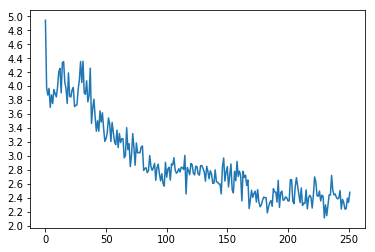

In [67]:
train(encoder, decoder, en_fr_trainloader, learning_rate=0.01, num_epochs=3, print_every=1000, plot_every=100, 
      max_seq_length=10, teacher_forcing_ratio=0.5, use_attention=False)